In [7]:
import pandas as pd

df = pd.read_csv('datasets\goemotions_cleaned.csv')
df = df.drop(columns=['id','example_very_unclear','emotion_num'])
df.head()

,text,emotion
0,That game hurt.,sadness
1,>sexuality shouldn’t be a grouping category I...,admiration
2,"You do right, if you don't care then fuck 'em!",neutral
3,Man I love reddit.,love
4,"[NAME] was nowhere near them, he was by the Fa...",neutral


In [18]:
ekman_mapping = {
"anger": ["anger", "annoyance", "disapproval"],
"disgust": ["disgust"],
"fear": ["fear", "nervousness"],
"joy": ["joy", "amusement", "approval", "excitement", "gratitude",  "love", "optimism", "relief", "pride", "admiration", "desire", "caring"],
"sadness": ["sadness", "disappointment", "embarrassment", "grief",  "remorse"],
"surprise": ["surprise", "realization", "confusion", "curiosity"]
}

ekman_mapping["neutral"] = ["neutral"]


reverse_mapping = {value: key for key, values in ekman_mapping.items() for value in values}
df["emotion"] = df["emotion"].map(reverse_mapping)

print(df['emotion'].value_counts())
df.head()

emotion
joy         82847
neutral     55298
anger       28802
surprise    22904
sadness     14494
fear         3460
disgust      3420
Name: count, dtype: int64


,text,emotion
0,That game hurt.,sadness
1,>sexuality shouldn’t be a grouping category I...,joy
2,"You do right, if you don't care then fuck 'em!",neutral
3,Man I love reddit.,joy
4,"[NAME] was nowhere near them, he was by the Fa...",neutral


In [19]:
from sklearn.utils import resample
target_count = min(df["emotion"].value_counts())

df_balanced = pd.concat([
    resample(group, replace=(len(group) < target_count), n_samples=target_count, random_state=42)
    for _, group in df.groupby("emotion")
])

df_balanced = df_balanced.sample(frac=1, random_state=42).reset_index(drop=True)
df_balanced["emotion"].value_counts()
print(df_balanced["emotion"].value_counts())
df_balanced.head()

emotion
sadness     3420
surprise    3420
fear        3420
disgust     3420
joy         3420
anger       3420
neutral     3420
Name: count, dtype: int64


,text,emotion
0,"Sorry guys, accidentally sold 10,000k",sadness
1,Related question: is there a level cap? EDIT: ...,surprise
2,"Other than family, I neither remember the last...",fear
3,*Ugh..* You are 23 and not married - leave.,disgust
4,I got grounded from reading once and it was th...,disgust


In [21]:
emotion_mapping = {emotion: idx for idx, emotion in enumerate(df_balanced["emotion"].unique())}

df_balanced["emotion"] = df_balanced["emotion"].map(emotion_mapping)
print(emotion_mapping)
df_balanced

{'sadness': 0, 'surprise': 1, 'fear': 2, 'disgust': 3, 'joy': 4, 'anger': 5, 'neutral': 6}


,text,emotion
0,"Sorry guys, accidentally sold 10,000k",0
1,Related question: is there a level cap? EDIT: ...,1
2,"Other than family, I neither remember the last...",2
3,*Ugh..* You are 23 and not married - leave.,3
4,I got grounded from reading once and it was th...,3
...,...,...
23935,"Wow, essential oils can now replace oxygen",1
23936,Taking the baby is the creepiest thing they’ve...,3
23937,Yeah Stupid Sexy groening,5
23938,Rash sun [NAME] dropping out of the first round?,6


In [20]:
%pip install matplotlib seaborn

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping
import tensorflow as tf

Note: you may need to restart the kernel to use updated packages.


In [23]:
X_train, X_test, y_train, y_test = train_test_split(
    df_balanced['text'], df_balanced['emotion'], test_size=0.3, random_state=42
)

In [24]:
max_words = 10000
max_len = 100
tokenizer = Tokenizer(num_words=max_words)
tokenizer.fit_on_texts(X_train)

In [57]:
X_train_seq = tokenizer.texts_to_sequences(X_train)
X_test_seq = tokenizer.texts_to_sequences(X_test)

X_train_pad = pad_sequences(X_train_seq, maxlen=max_len)
X_test_pad = pad_sequences(X_test_seq, maxlen=max_len)

num_classes = df_balanced['emotion'].nunique()
y_train_cat = tf.keras.utils.to_categorical(y_train, num_classes=num_classes)
y_test_cat = tf.keras.utils.to_categorical(y_test, num_classes=num_classes)
num_classes

7

In [46]:
from tensorflow.keras.models import Model
from tensorflow.keras.regularizers import l2
from tensorflow.keras.layers import Input, Attention

# model = Sequential()
# model.add(Embedding(max_words, 128, input_length=max_len))
# model.add(LSTM(128, dropout=0.3, recurrent_dropout=0.3, return_sequences=True))
# model.add(LSTM(64, dropout=0.3, recurrent_dropout=0.3))
# model.add(Dense(64, activation='relu', kernel_regularizer=l2(0.01)))
# model.add(Attention())
# model.add(Dropout(0.5))
# model.add(Dense(num_classes, activation='softmax'))

# model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

# model.summary()

input_layer = Input(shape=(max_len,))

embedding = Embedding(max_words, 128, input_length=max_len)(input_layer)

lstm1 = LSTM(128, dropout=0.3, recurrent_dropout=0.3, return_sequences=True)(embedding)
lstm2 = LSTM(64, dropout=0.3, recurrent_dropout=0.3, return_sequences=True)(lstm1)

query = Dense(64)(lstm2)  
attention = Attention()([query, lstm2])  

dense = Dense(64, activation='relu', kernel_regularizer=l2(0.01))(attention)
dropout = Dropout(0.5)(dense)
output_layer = Dense(num_classes, activation='softmax')(dropout)

model = Model(inputs=input_layer, outputs=output_layer)

model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 100)]        0           []                               
                                                                                                  
 embedding_6 (Embedding)        (None, 100, 128)     1280000     ['input_2[0][0]']                
                                                                                                  
 lstm_9 (LSTM)                  (None, 100, 128)     131584      ['embedding_6[0][0]']            
                                                                                                  
 lstm_10 (LSTM)                 (None, 100, 64)      49408       ['lstm_9[0][0]']                 
                                                                                              

In [47]:
early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

In [ ]:
history = model.fit(
    X_train_pad, y_train_cat,
    epochs=20,
    batch_size=64,
    validation_data=(X_test, y_test_cat),
    callbacks=[early_stopping]
)

Epoch 1/20
210/210 [==============================] - 184s 863ms/step - loss: 2.1275 - accuracy: 0.1655 - val_loss: 1.9157 - val_accuracy: 0.2145
Epoch 2/20
210/210 [==============================] - 176s 840ms/step - loss: 1.8161 - accuracy: 0.2643 - val_loss: 1.7785 - val_accuracy: 0.3070
Epoch 3/20
210/210 [==============================] - 179s 854ms/step - loss: 1.6387 - accuracy: 0.3792 - val_loss: 1.7265 - val_accuracy: 0.3649
Epoch 4/20
210/210 [==============================] - 180s 857ms/step - loss: 1.4653 - accuracy: 0.4886 - val_loss: 1.7150 - val_accuracy: 0.3881
Epoch 5/20
210/210 [==============================] - 179s 850ms/step - loss: 1.3179 - accuracy: 0.5600 - val_loss: 1.7459 - val_accuracy: 0.3968
Epoch 6/20
210/210 [==============================] - 178s 850ms/step - loss: 1.1849 - accuracy: 0.6221 - val_loss: 1.8809 - val_accuracy: 0.3801
Epoch 7/20
210/210 [==============================] - 179s 852ms/step - loss: 1.0767 - accuracy: 0.6685 - val_loss: 1.9169 -

In [37]:
loss, accuracy = model.evaluate(X_test_pad, y_test_cat)
print(f"Test Loss: {loss:.4f}")
print(f"Test Accuracy: {accuracy:.4f}")

225/225 [==============================] - 19s 82ms/step - loss: 1.7434 - accuracy: 0.3871
Test Loss: 1.7434
Test Accuracy: 0.3871


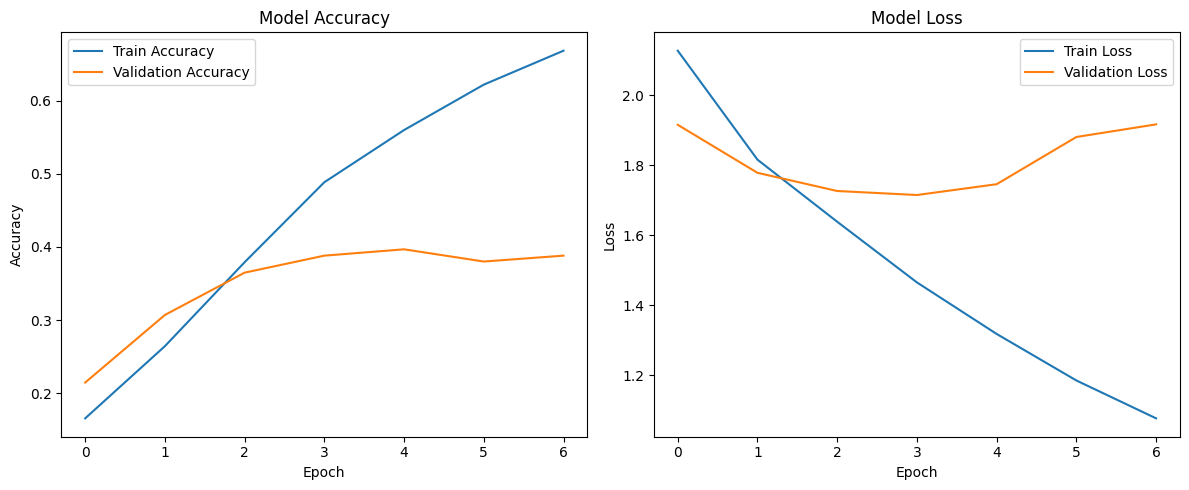

In [39]:
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.savefig('models/version2/training_history.png')
plt.show()

In [40]:
y_pred_probs = model.predict(X_test_pad)
y_pred = np.argmax(y_pred_probs, axis=1)
y_test_labels = np.array(y_test)

225/225 [==============================] - 19s 82ms/step


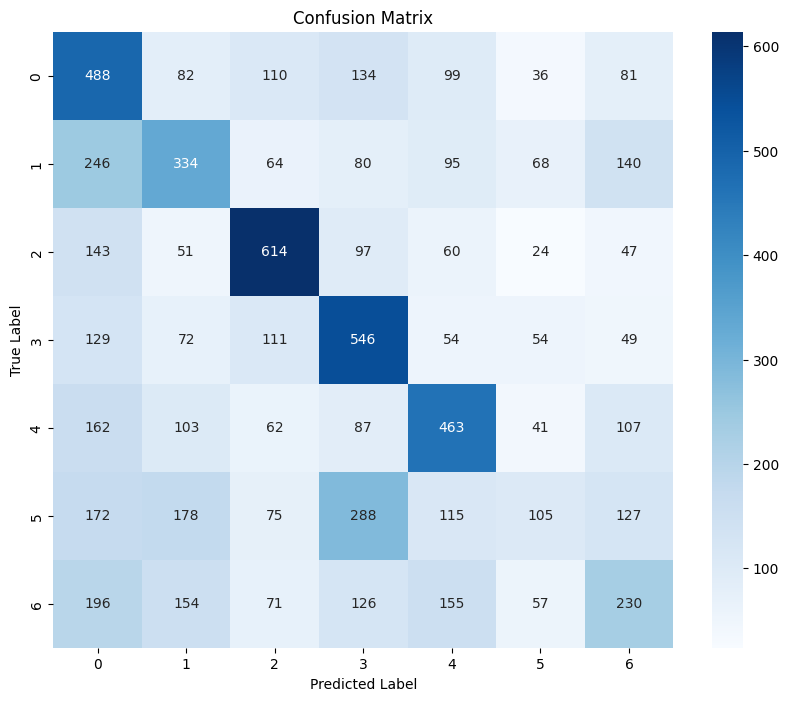

In [48]:
cm = confusion_matrix(y_test_labels, y_pred)
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.savefig('models/version2/confusion_matrix.png')
plt.show()

In [49]:
print("Classification Report:")
print(classification_report(y_test_labels, y_pred))

Classification Report:
              precision    recall  f1-score   support

           0       0.32      0.47      0.38      1030
           1       0.34      0.33      0.33      1027
           2       0.55      0.59      0.57      1036
           3       0.40      0.54      0.46      1015
           4       0.44      0.45      0.45      1025
           5       0.27      0.10      0.15      1060
           6       0.29      0.23      0.26       989

    accuracy                           0.39      7182
   macro avg       0.38      0.39      0.37      7182
weighted avg       0.38      0.39      0.37      7182



In [51]:
model.save('models/version2/emotion_prediction_model.h5')

import pickle
with open('models/version2/tokenizer.pickle', 'wb') as handle:
    pickle.dump(tokenizer, handle, protocol=pickle.HIGHEST_PROTOCOL)